<a href="https://colab.research.google.com/github/trsekhar123/DistilBERTExplainer/blob/main/Demo_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install transformers>=2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [ ]:
!git clone https://github.com/trsekhar123/DistilBERTExplainer.git

fatal: destination path 'DistilBERTExplainer' already exists and is not an empty directory.


In [ ]:
!pip install /content/DistilBERTExplainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./DistilBERTExplainer
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for explain-lib: filename=explain_lib-1.0-py3-none-any.whl size=10069 sha256=35b296ad3cda948218dc89c6c3c9a968c19f1d1bead8fffb80d331f914d3b6b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9f616vr/wheels/f2/9e/71/0b758d83786d12f003c28b758c17e574aa8d07b16b9d9bb0d2
Successfully built explain-lib
  Attempting uninstall: explain-lib
    Found existing installation: explain-lib 1.0
    Uninstalling explain-lib-1.0:
      Successfully uninstalled explain

In [ ]:
import pandas as pd
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
batch_1 = df[:100]
batch_1[1].value_counts()

1    60
0    40
Name: 1, dtype: int64

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from explain_lib.distilbert_utils import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',output_hidden_states=True, output_attentions=True)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
# loss, logits = outputs[:2]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['output.0.bias', 'output.0.weight']
You should probably

In [ ]:
eval=df.iloc[100:105].reset_index(drop=True)

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (add1): Add()
      (add2): Add()
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (matmul1): MatMul()
            (matmul2): MatMul()
            (softmax

### Model Training

In [ ]:
from tqdm import tqdm
import os.path as op
epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    for step, (inputs, labels) in enumerate(batch_1[[0,1]].values):
      input_ids = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)
      labels = torch.tensor([labels]).unsqueeze(0).to(device)
      # initialize calculated gradients (from prev step)
      optim.zero_grad()
      # pull all tensor batches required for training
      # process
      outputs,attention_weights,hidden_states = model(input_ids)
      output_final = (F.softmax(outputs).detach().numpy()[0][1])
      # extract loss
      loss=criterion(F.softmax(outputs),labels[0])
      # loss = outputs.loss
      # calculate loss for every parameter that needs grad update
      loss.backward()
      # update parameters
      optim.step()
      # print relevant info to progress bar
      # loop.set_description(f'Epoch {epoch}')
      # loop.set_postfix(loss=loss.item())

      torch.save({'model': model.state_dict(),'attentions':attention_weights},
                        op.join(f"fold{epoch}_best.pth"))

In [ ]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

## AGrad

<ipython-input-23-1646916c946b>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_final.append(F.softmax(outputs[0]).detach().numpy()[0][1])


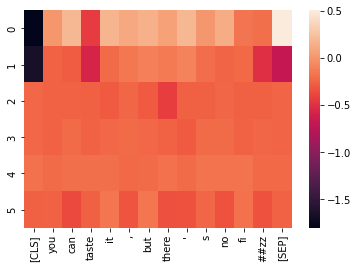

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn

output_final = []

for text, label in eval.iloc[:6][[0,1]].values:
  input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
  labels = torch.tensor([label]).unsqueeze(0)  # Batch size 1
  outputs = model(input_ids)
  output_final.append(F.softmax(outputs[0]).detach().numpy()[0][1])

  hidden_states_new=torch.stack(outputs[2]).squeeze()

  att_weights_new=torch.stack(outputs[1]).squeeze()

  attent_hidden=torch.einsum("lass,lsh->lash",att_weights_new,hidden_states_new[:6])
  plt.figure() #this creates a new figure on which your plot will appear
  # seaborn.countplot(use_df);bbb
  sns.heatmap(((attent_hidden.sum(dim=-1).sum(dim=1))/norm_fn(attent_hidden)).detach().numpy()[:,:len(input_ids[0])],xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0])[:len(input_ids[0])])
  break

## RePAGrad

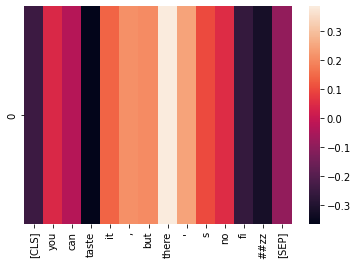

In [ ]:

for text, label in eval.iloc[:6][[0,1]].values:
  input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
  labels = torch.tensor([label]).unsqueeze(0)  # Batch size 1
  outputs = model(input_ids)
  cam2=model.distilbert.transformer.relprop(outputs[2][0],alpha=0.3)
  plt.figure()
  sns.heatmap((cam2.sum(-1)/norm_fn(cam2)).detach().numpy(),xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0])[:len(input_ids[0])])
  break

<ipython-input-27-546c04fb9722>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cam2=model.relprop(F.softmax(outputs[0]),alpha=0.3)[0]


tensor([[0.0094, 0.9906]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 768])


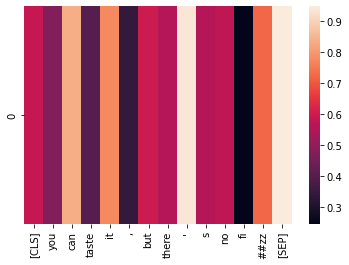

In [ ]:
for text, label in eval.iloc[0:2][[0,1]].values:
  input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
  labels = torch.tensor([label]).unsqueeze(0)  # Batch size 1
  outputs = model(input_ids)
  cam2=model.relprop(F.softmax(outputs[0]),alpha=0.3)[0]
  plt.figure()
  sns.heatmap((cam2.sum(-1)/norm_fn(cam2)).detach().numpy(),xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0])[:len(input_ids[0])])
  break

#    Validation of results before and after LRP - Save the preditions scores before and after LRP

In [ ]:
prediction_before = []
prediction_after = []
for text, label in eval[[0,1]].values:
  print(text)
  input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
  labels = torch.tensor([label]).unsqueeze(0)  # Batch size 1
  outputs = model(input_ids)
  cam2=model.relprop(F.softmax(outputs[0]),alpha=0.3)[0]
  df_attr=pd.DataFrame({'token_ids':input_ids[0].detach().numpy(),'token_text':tokenizer.convert_ids_to_tokens(input_ids[0])[:len(input_ids[0])],'attribution':(cam2.sum(-1)/norm_fn(cam2)).detach().numpy()[0]})
  if F.softmax(outputs[0])[0,1]>0.5:
    test_tokens=[i for i in df_attr.nlargest(2,'attribution').token_ids.values if i != 101 and i !=102]
  else:
    test_tokens=[i for i in df_attr.nsmallest(2,'attribution').token_ids.values if i != 101 and i !=102]
  df_attr.loc[df_attr.token_ids.isin(test_tokens),'token_ids']=102
  outputs2 = model(torch.tensor(df_attr['token_ids']).unsqueeze(0)) 
  prediction_before.append(F.softmax(outputs[0]).detach().numpy()[0][1])
  prediction_after.append(F.softmax(outputs2[0]).detach().numpy()[0][1])

you can taste it , but there 's no fizz


<ipython-input-43-abca073ee097>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cam2=model.relprop(F.softmax(outputs[0]),alpha=0.3)[0]
<ipython-input-43-abca073ee097>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if F.softmax(outputs[0])[0,1]>0.5:


tensor([[0.0102, 0.9898]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 768])


<ipython-input-43-abca073ee097>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction_before.append(F.softmax(outputs[0]).detach().numpy()[0][1])
<ipython-input-43-abca073ee097>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction_after.append(F.softmax(outputs2[0]).detach().numpy()[0][1])


a reworking of die hard and cliffhanger but it 's nowhere near as exciting as either
tensor([[0.0115, 0.9885]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 768])
a moving tale of love and destruction in unexpected places , unexamined lives
tensor([[0.0083, 0.9917]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 768])
it has more than a few moments that are insightful enough to be fondly remembered in the endlessly challenging maze of moviegoing
tensor([[0.0092, 0.9908]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 768])
why ?
tensor([[0.0125, 0.9875]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 768])


#    Validation of results before and after LRP - Save the preditions scores before and after RePAGrad

In [ ]:
prediction_before_repa = []
prediction_after_repa = []
for text, label in eval[[0,1]].values:
  print(text)
  input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
  labels = torch.tensor([label]).unsqueeze(0)  # Batch size 1
  outputs = model(input_ids)
  cam2=model.distilbert.transformer.relprop(outputs[2][0],alpha=0.3)
  df_attr=pd.DataFrame({'token_ids':input_ids[0].detach().numpy(),'token_text':tokenizer.convert_ids_to_tokens(input_ids[0])[:len(input_ids[0])],'attribution':(cam2.sum(-1)/norm_fn(cam2)).detach().numpy()[0]})
  if F.softmax(outputs[0])[0,1]>0.5:
    test_tokens=[i for i in df_attr.nlargest(2,'attribution').token_ids.values if i != 101 and i !=102]
  else:
    test_tokens=[i for i in df_attr.nsmallest(2,'attribution').token_ids.values if i != 101 and i !=102]
  df_attr.loc[df_attr.token_ids.isin(test_tokens),'token_ids']=102
  outputs2 = model(torch.tensor(df_attr['token_ids']).unsqueeze(0)) 
  prediction_before_repa.append(F.softmax(outputs[0]).detach().numpy()[0][1])
  prediction_after_repa.append(F.softmax(outputs2[0]).detach().numpy()[0][1])

you can taste it , but there 's no fizz


<ipython-input-44-4d852099ee7e>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if F.softmax(outputs[0])[0,1]>0.5:
<ipython-input-44-4d852099ee7e>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction_before_repa.append(F.softmax(outputs[0]).detach().numpy()[0][1])
<ipython-input-44-4d852099ee7e>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction_after_repa.append(F.softmax(outputs2[0]).detach().numpy()[0][1])


a reworking of die hard and cliffhanger but it 's nowhere near as exciting as either
a moving tale of love and destruction in unexpected places , unexamined lives
it has more than a few moments that are insightful enough to be fondly remembered in the endlessly challenging maze of moviegoing
why ?


In [ ]:
df_lrp = pd.DataFrame({'labels':eval[1],'pred_before':prediction_before,'pred_after':prediction_after,'pred_repa_before':prediction_before_repa,'pred_repa_after':prediction_after_repa})

# AUC Comparison

## AUC of Model

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_lrp['labels'],df_lrp['pred_before'])

1.0

## AUC of Model after LRP

In [ ]:
roc_auc_score(df_lrp['labels'],df_lrp['pred_after'])

0.33333333333333337

## AUC of Model after RePAGrad

In [ ]:
roc_auc_score(df_lrp['labels'],df_lrp['pred_repa_after'])

0.0

## Comparison Between LRP and RePAGrad (Log Odds Score)

### Error With RePAGRad

In [ ]:
import numpy as np
np.mean(np.abs((-np.log(df_lrp['pred_repa_before']))-(-np.log(df_lrp['pred_repa_after']))))

0.00216861

### Error With LRP

In [ ]:
np.mean(np.abs((-np.log(df_lrp['pred_before']))-(-np.log(df_lrp['pred_after']))))

0.0023586676

## Comparison Between LRP and RePAGrad (Comprehensiveness)

### Error With RePAGRad

In [ ]:
import numpy as np
np.mean(np.abs(df_lrp['pred_repa_before'] - df_lrp['pred_repa_after']))

0.0021487593

### Error With LRP

In [ ]:
np.mean(np.abs(df_lrp['pred_before'] - df_lrp['pred_after']))

0.0023347258